In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec
import cmocean

In [2]:
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as mcolors

In [3]:
save_path = '/sciserver/filedb06-03/ocean/wenrui_temp/'
rad = xr.open_zarr(save_path+'eras5_heat_flux.zarr')
flx = xr.open_zarr(save_path+'eras5_integrated_flux.zarr')
mass = xr.open_zarr(save_path+'eras5_col_mass.zarr')
clh = xr.open_zarr(save_path+'eras5_tot_heat.zarr')
reg = xr.open_zarr(save_path+'eras5_cloud_wind.zarr')
moi = xr.open_zarr(save_path+'eras5_latent.zarr')
sstm = xr.open_zarr(save_path+'eras5_sst.zarr')

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.38.0 or higher is recommended. You are running version 2.23.0
  warnings.warn(


In [4]:
from matplotlib.font_manager import FontProperties

In [5]:
ds = xr.merge([flx,mass,clh,reg,moi,sstm],combine_attrs  = 'drop_conflicts')

In [6]:
x = np.array(rad.longitude)
y = np.array(rad.latitude)

In [7]:
for var in rad.data_vars:
    ds[var] = xr.DataArray(rad[var].data,dims = ('time','latitude','longitude'),attrs = rad[var].attrs)

In [8]:
ds['tm'] = clh['p54.162']/mass['col_mass']
ds['tm'].attrs['long_name'] = 'Vertical averaged temperature'
ds['tm'].attrs['GRIB_units'] = 'K'

In [9]:
ds['wspd'] = np.hypot(reg['u10'],reg['v10'])
ds['wspd'].attrs['long_name'] = '10m wind speed'
ds['wspd'].attrs['GRIB_units'] = 'm/s'

In [10]:
ds['latent'].attrs['long_name'] = 'Column integrated latent energy'
ds['latent'].attrs['GRIB_units'] = 'J m**-2'

In [11]:
unit_lookup = {
    'J m**-2': r'$\mathrm{J/m^{-2}}$',
    'W m**-2': r'$\mathrm{W\cdot m^{-2}}$',
    'm/s':r'$\mathrm{m/s}$',
    'K':r'$^\circ \mathrm{C}$',
    'kg m**-2 s**-1':r'$\mathrm{kg\cdot m^{-2} s^{-2}}$'
}

In [12]:
x = np.array(rad.longitude)
y = np.array(rad.latitude)

In [13]:
start = np.searchsorted(x, 200, side='left')
end = np.searchsorted(x, 235, side='right')
xslc = slice(start,end)
start = np.searchsorted(y[::-1], 35, side='left')
end = np.searchsorted(y[::-1], 60, side='right')
yslc = slice(-end,-start)

In [14]:
y[yslc][[1,-1]],x[xslc][[1,-1]]

(array([59.75, 35.  ]), array([200.25, 235.  ]))

In [15]:
mask = 1-np.isnan(ds.sst)

In [16]:
nts = xr.Dataset()
nts['time'] = rad.time
# mask = 1
control = (xr.ones_like(rad['mslhf'])*np.cos(rad.latitude*np.pi/180)*mask).isel(longitude = xslc,latitude = yslc).sum(dim = ('longitude','latitude'))
for var in rad.data_vars:
    if var[0] =='m':
        nts[var] = (rad[var]*np.cos(rad.latitude*np.pi/180)*mask).isel(longitude = xslc,latitude = yslc).sum(dim = ('longitude','latitude'))/control
        nts[var] = nts[var].persist()

In [17]:
nss = nts.groupby('time.month').mean('time').persist()

In [18]:
rad_color = {
    "mslhf":"#ff7f00",
    "msshf":"#984ea3",
    "msnlwrf":"#377eb8",
    "msnswrf":"#4daf4a",
}

# rad_color = {
#     "msnlwrf":"#e78ac3",
#     "msnswrf":"#66c2a5",
#     "mslhf":"#fc8d62",
#     "msshf":"#8da0cb"
# }

In [45]:
intensification_slc = slice(275,278)
intensification_month = [11,0,1]

In [46]:
rad.time[intensification_slc.start].values

numpy.datetime64('2014-11-30T18:00:00.000000000')

In [47]:
mm = 1/25.4

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]


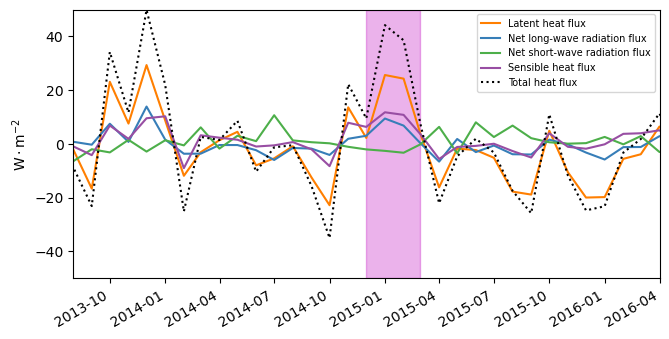

In [48]:
def plt_rad_time(ax):
    sums = np.zeros(312)
    for var in nts.data_vars:
        if var in rad_color.keys():
            label = rad[var].long_name[13:]
            label = label[0].upper()+label[1:]
            the_term = np.array(nts[var].groupby('time.month')- nss[var])
            ax.plot(rad.time,the_term,label = label,color = rad_color[var])
            sums+=the_term
    ax.plot(rad.time,sums,label = 'Total heat flux',color = 'k',linestyle = ':')
    ax.set_xlim(np.datetime64('2013-08'),np.datetime64('2016-04'))
    ax.set_ylim(-50,50)
    ax.legend(fontsize = 7)
    ax.set_ylabel(r"$\mathrm{W\cdot m^{-2}}$")
    ax.axvspan(rad.time[intensification_slc.start].values, rad.time[intensification_slc.stop].values, color='m', alpha=0.3)

fig = plt.figure(figsize = (180*mm,90*mm))
ax = plt.axes()
plt_rad_time(ax)
plt.tight_layout()
fig.autofmt_xdate()

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]


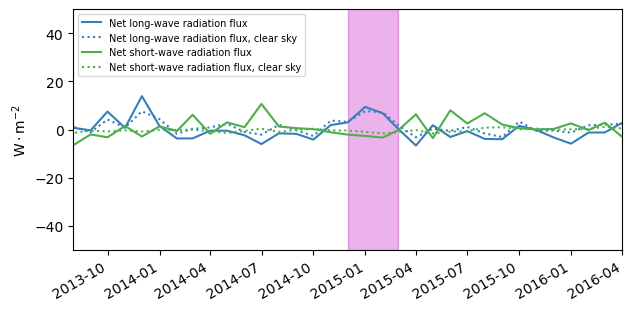

In [49]:
# sums = np.zeros(312)
def plt_supp_clear_sky(ax):
    for var in nts.data_vars:
        if 'msn' in var:
            if 'sw' in var:
                color = rad_color["msnswrf"]
            elif 'lw' in var:
                color = rad_color["msnlwrf"]
            if 'cs' in var:
                ls = ':'
            else:
                ls = '-'
            label = rad[var].long_name[13:]
            label = label[0].upper()+label[1:]
            the_term = np.array(nts[var].groupby('time.month')- nss[var])
            ax.plot(rad.time,the_term,label = label,color = color,linestyle = ls)
    plt.xlim(np.datetime64('2013-08'),np.datetime64('2016-04'))
    ax.set_ylim(-50,50)
    plt.legend(fontsize = 7)
    ax.set_ylabel(r"$\mathrm{W\cdot m^{-2}}$")
    ax.axvspan(rad.time[intensification_slc.start].values, rad.time[intensification_slc.stop].values, color='m', alpha=0.3)
fig = plt.figure(figsize = (180*mm,90*mm))
ax =  plt.axes()
plt_supp_clear_sky(ax)
fig.autofmt_xdate()
plt.savefig('sup_clear_sky.pdf',dpi = 300)

In [50]:
seas = ds.groupby('time.month').mean('time')

In [51]:
# intensification_slc = slice(260,265)
# intensification_month = [8,9,10,11]

In [52]:
# intensification_slc = slice(8,12)
# intensification_month = [8,9,10,11]

In [53]:
projection = ccrs.Mercator(central_longitude=180.0, 
                           min_latitude=20.0, 
                           max_latitude=80.0,
                           latitude_true_scale=40.0)

In [54]:
import matplotlib.colors as mc

In [55]:
vars = ['latent','d2m','tm','t2m','wspd','mslhf','msshf','msnlwrf','msnswrf']

In [56]:
qx = flx['adv_q_x'].isel(time = intensification_slc).mean(dim = 'time')
qy = flx['adv_q_y'].isel(time = intensification_slc).mean(dim = 'time')

tx = flx['adv_t_x'].isel(time = intensification_slc).mean(dim = 'time')
ty = flx['adv_t_y'].isel(time = intensification_slc).mean(dim = 'time')

qxs = seas['adv_q_x'].isel(month = intensification_month).mean(dim = 'month')
qys = seas['adv_q_y'].isel(month = intensification_month).mean(dim = 'month')

txs = seas['adv_t_x'].isel(month = intensification_month).mean(dim = 'month')
tys = seas['adv_t_y'].isel(month = intensification_month).mean(dim = 'month')

slp = ds.msl.isel(time = intensification_slc).mean(dim = 'time')
slp_s = seas.msl.isel(month = intensification_month).mean(dim = 'month')

In [57]:
sparce = slice(None,None,32)
quick = slice(None)
def plt_small_map(ax,var,fontsize = 7,vmax = False,cmap = 'bwr',add_tarrow = False,add_qarrow = False,colorbar = True,shrink = 0.8,lw = 0.005,add_slp = False,plot_anom = True):
    if plot_anom:
        array = (ds[var].isel(time = intensification_slc).mean(dim = 'time') - seas[var].isel(month = intensification_month).mean(dim = 'month')).persist()
    else:
        array = seas[var].isel(month = intensification_month).mean(dim = 'month').persist()
    if vmax:
        ct = ax.pcolormesh(x[quick],y[quick],array[quick,quick],transform = ccrs.PlateCarree(),
                           cmap = cmap,vmax = vmax,vmin = -vmax,zorder = 1,
                           linewidth = 0,rasterized = True,
                          )
    else:
        ct = ax.pcolormesh(x[quick],y[quick],array[quick,quick],transform = ccrs.PlateCarree(),
                           cmap = cmap,norm = mc.CenteredNorm(),zorder = 1,
                           linewidth = 0,rasterized = True,
                          )
    font_prop = FontProperties(size=fontsize-1)
    if add_tarrow:
        qv = ax.quiver(x[sparce],y[sparce],
                       np.array(tx[sparce,sparce]-txs[sparce,sparce]),
                       np.array(ty[sparce,sparce]-tys[sparce,sparce]),
                       transform = ccrs.PlateCarree(),color = 'brown',width = lw)
        qk = ax.quiverkey(qv,X=0.65, Y=0.95, U=2e10, label=r'$2\times10^{10} \mathrm{W/m}$', labelpos='E', transform=ax.transAxes,fontproperties=font_prop)
        qk.set_zorder(10)
    elif add_qarrow:
        qv = ax.quiver(x[sparce],y[sparce],
                       np.array(qx[sparce,sparce]-qxs[sparce,sparce]),
                       np.array(qy[sparce,sparce]-qys[sparce,sparce]),
                       transform = ccrs.PlateCarree(),color = 'm',width = lw)
        qk = ax.quiverkey(qv,X=0.65, Y=0.95, U=100, label=r'$100 kg\cdot m^{-1}s^{-1}$', 
                          labelpos='E', transform=ax.transAxes,fontproperties=font_prop)
        qk.set_zorder(10)
    if add_slp:
        cs = ax.contour(x,y,(slp-slp_s)/100,transform = ccrs.PlateCarree(),colors = 'grey',levels = 15,linewidths = 0.5)
        ax.clabel(cs)
    ax.set_extent([-200,-110,15,65],crs = ccrs.PlateCarree())
    label = ds[var].long_name
    if 'ms' in var:
        label = label[13:]
    label = label[0].upper()+label[1:]
    ax.set_title(label,fontsize = fontsize)
    gl = ax.gridlines(draw_labels = True,linestyle="--", linewidth=0.5)
    gl.top_labels = False
    gl.right_labels= False
    gl.xlabel_style = {'size':fontsize}
    gl.ylabel_style = {'size':fontsize}
    ax.add_feature(cfeature.LAND,facecolor = 'grey',zorder = 8)
    if colorbar:
        cb = plt.colorbar(ct,extend = 'both',shrink = shrink,aspect = 30)
        cb.ax.tick_params(labelsize=fontsize)
        cb.set_label(unit_lookup[ds[var].attrs['GRIB_units']],fontsize = fontsize)
        cb.ax.yaxis.get_offset_text().set_fontsize(fontsize)

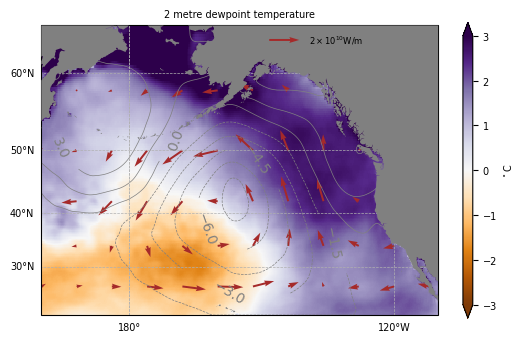

In [58]:
ax = plt.axes(projection = projection)
var = 'd2m'
plt_small_map(ax,var,vmax = 3,cmap = 'PuOr',add_tarrow = True,add_slp = True)

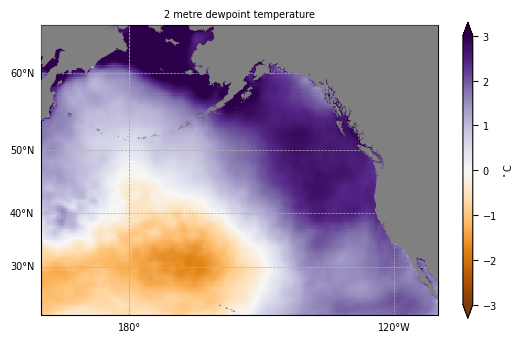

In [59]:
ax = plt.axes(projection = projection)
var = 'd2m'
plt_small_map(ax,var,vmax = 3,cmap = 'PuOr')

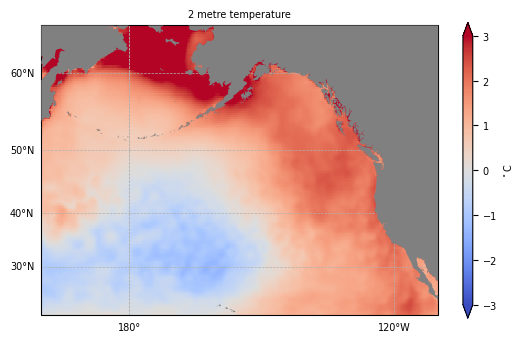

In [60]:
ax = plt.axes(projection = projection)
var = 't2m'
plt_small_map(ax,var,vmax = 3,cmap = 'coolwarm')

In [33]:
def plot_colorbar_in_cax(vmin, vmax, cmap, cax, **kwargs):
    """
    Plot a colorbar in the given cax using specified vmin, vmax, and colormap.

    Parameters:
        vmin (float): Minimum value of the color scale.
        vmax (float): Maximum value of the color scale.
        cmap (str or Colormap): The colormap to use.
        cax (matplotlib.axes.Axes): The axes to draw the colorbar in.
        **kwargs: Additional keyword arguments passed to plt.colorbar().
    """
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    # sm.set_array([])  # Required by plt.colorbar
    return plt.colorbar(sm, cax=cax, **kwargs)

In [34]:
fontsize = 7

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]


mslhf
msshf
msnlwrf
msnswrf
d2m
t2m


/tmp/ipykernel_2307358/3576224440.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


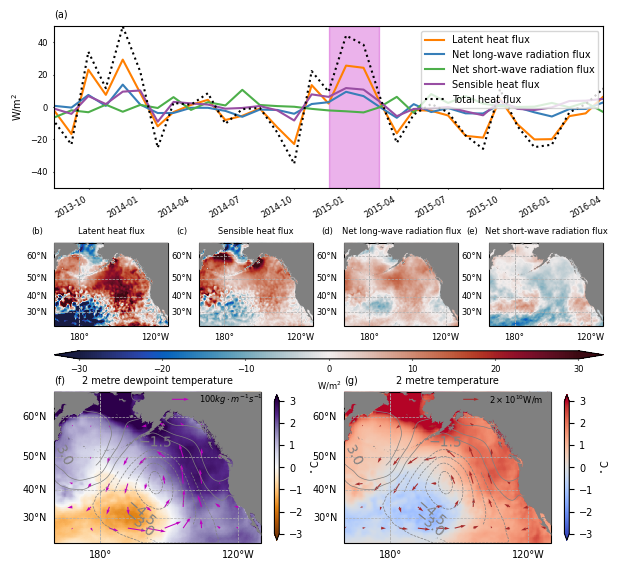

In [35]:
fig = plt.figure(figsize = (180*mm,195*mm))
gs = GridSpec(6,4,height_ratios = [1,0.15,0.75,0.05,0.1,1],wspace = 0.27,hspace = 0.07)
ax = fig.add_subplot(gs[:1,:])
ax.set_title('(a)',loc = 'left',fontsize = fontsize)
plt_rad_time(ax)
ax.tick_params(axis='both', labelsize=fontsize-1,length = 1)
ax.set_ylabel(r'$\mathrm{W/m^2}$',fontsize = fontsize)
fig.autofmt_xdate()

for i,var in enumerate(rad_color.keys()):
    print(var)
    ax = fig.add_subplot(gs[2,i],projection = projection)
    plt_small_map(ax,var,vmax = 30,cmap = cmocean.cm.balance,colorbar = False,fontsize = 6)
    ax.set_title(f'({chr(98+i)})',loc = 'left',fontsize = 6,x = -0.2)
    
cax = fig.add_subplot(gs[3,:])
cb1 = plot_colorbar_in_cax(-30, 30, cmocean.cm.balance, cax,extend = 'both',orientation = 'horizontal',aspect = 70)
cb1.ax.tick_params(labelsize=fontsize-1,length = 1)
cb1.set_label(r'$\mathrm{W/m^2}$',fontsize = fontsize-1)

print('d2m')
ax = fig.add_subplot(gs[-1,:2],projection = projection)
ax.set_title('(f)',loc = 'left',fontsize = fontsize)
plt_small_map(ax,'d2m',vmax = 3,cmap = 'PuOr',add_qarrow = True,shrink = 0.9,add_slp = True)

print('t2m')
ax = fig.add_subplot(gs[-1,2:],projection = projection)
ax.set_title('(g)',loc = 'left',fontsize = fontsize)
plt_small_map(ax,'t2m',vmax = 3,cmap = 'coolwarm',add_tarrow = True,shrink = 0.9,add_slp = True)

plt.tight_layout()
plt.savefig('fig5.pdf',dpi = 300,format = 'pdf')

In [36]:
# fig = plt.figure(figsize = (180*mm,240*mm))
# gs = GridSpec(6,4,height_ratios = [1,0.15,0.75,0.05,0.1,1],wspace = 0.3,hspace = 0.)
# ax = fig.add_subplot(gs[:1,:])
# ax.set_title('(a)',loc = 'left',fontsize = fontsize)
# plt_rad_time(ax)
# ax.tick_params(axis='both', labelsize=fontsize)
# fig.autofmt_xdate()

# for i,var in enumerate(rad_color.keys()):
#     print(var)
#     ax = fig.add_subplot(gs[2,i],projection = projection)
#     plt_small_map(ax,var,vmax = 30,cmap = cmocean.cm.balance,colorbar = False,fontsize = 6)
#     ax.set_title(f'({chr(98+i)})',loc = 'left',fontsize = 6,x = -0.2)
    
# cax = fig.add_subplot(gs[3,:])
# cb1 = plot_colorbar_in_cax(-30, 30, cmocean.cm.balance, cax,extend = 'both',orientation = 'horizontal',aspect = 70)
# cb1.ax.tick_params(labelsize=fontsize-1,length = 1)
# cb1.set_label(r'$\mathrm{W/m^2}$',fontsize = fontsize-1)

# print('d2m')
# ax = fig.add_subplot(gs[4:,:2],projection = projection)
# ax.set_title('(f)',loc = 'left',fontsize = fontsize)
# plt_small_map(ax,'d2m',vmax = 3,cmap = 'PuOr',add_qarrow = True,shrink = 0.55)

# print('t2m')
# ax = fig.add_subplot(gs[4:,2:],projection = projection)
# ax.set_title('(g)',loc = 'left',fontsize = fontsize)
# plt_small_map(ax,'t2m',vmax = 3,cmap = 'coolwarm',add_tarrow = True,shrink = 0.55)

# plt.savefig('fig5.pdf',dpi = 300,format = 'pdf')
# # plt.tight_layout()

latent
tm
div_q
div_t
wspd
hey


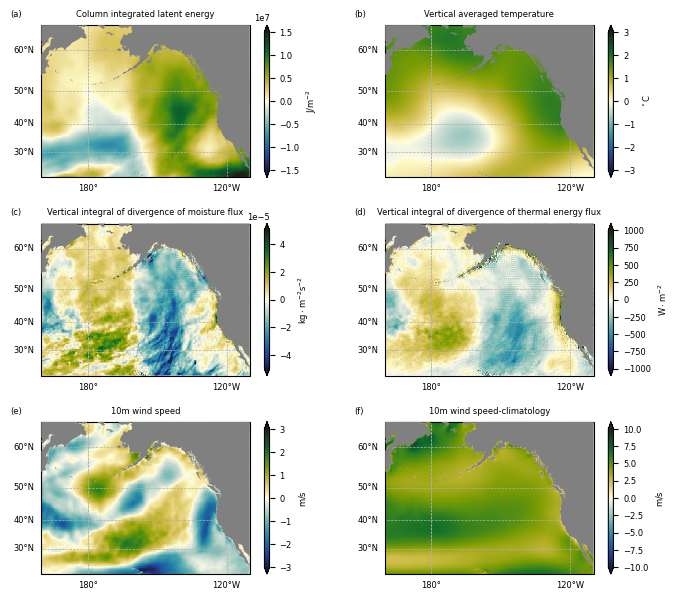

In [37]:
fig = plt.figure(figsize = (180*mm,155*mm))
# gs = GridSpec(2,2)
vmaxs = [1.5e7,3,5e-5,1000,3]
for i,var in enumerate(['latent','tm','div_q','div_t','wspd']):
    print(var)
    ax = plt.subplot(3,2,i+1,projection = projection)
    plt_small_map(ax,var,cmap = cmocean.cm.delta,fontsize = 6,shrink = 1,vmax = vmaxs[i])
    ax.set_title(f'({chr(97+i)})',loc = 'left',fontsize = 6,x = -0.15)
print('hey')
ax = plt.subplot(3,2,6,projection = projection)
plt_small_map(ax,'wspd',cmap = cmocean.cm.delta,fontsize = 6,shrink = 1,plot_anom = False,vmax = 10)
ax.set_title('10m wind speed-climatology',fontsize = 6)
ax.set_title('(f)',loc = 'left',fontsize = 6,x = -0.15)
plt.tight_layout()
plt.savefig('sup_heat_flux_more.pdf',dpi = 300)

In [38]:
intensification_slc = slice(261,264)
intensification_month = [9,10,11]

In [39]:
qx = flx['adv_q_x'].isel(time = intensification_slc).mean(dim = 'time')
qy = flx['adv_q_y'].isel(time = intensification_slc).mean(dim = 'time')

tx = flx['adv_t_x'].isel(time = intensification_slc).mean(dim = 'time')
ty = flx['adv_t_y'].isel(time = intensification_slc).mean(dim = 'time')

qxs = seas['adv_q_x'].isel(month = intensification_month).mean(dim = 'month')
qys = seas['adv_q_y'].isel(month = intensification_month).mean(dim = 'month')

txs = seas['adv_t_x'].isel(month = intensification_month).mean(dim = 'month')
tys = seas['adv_t_y'].isel(month = intensification_month).mean(dim = 'month')

slp = ds.msl.isel(time = intensification_slc).mean(dim = 'time')
slp_s = seas.msl.isel(month = intensification_month).mean(dim = 'month')

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]


mslhf
msshf
msnlwrf
msnswrf
d2m
t2m


/tmp/ipykernel_2307358/3878405843.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


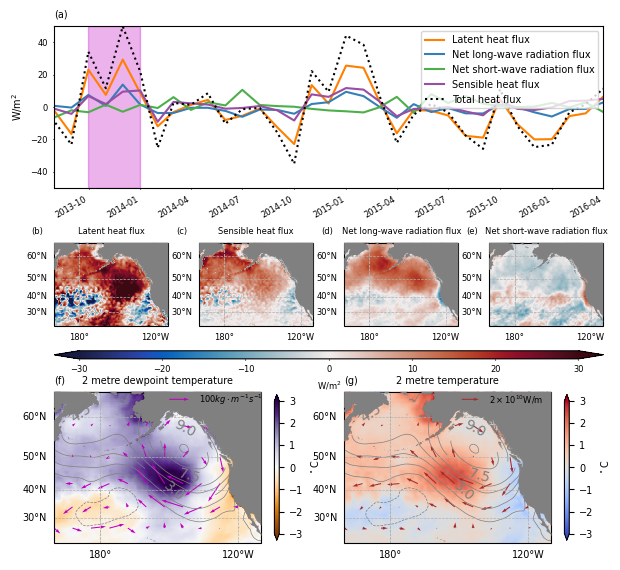

In [40]:
fig = plt.figure(figsize = (180*mm,195*mm))
gs = GridSpec(6,4,height_ratios = [1,0.15,0.75,0.05,0.1,1],wspace = 0.27,hspace = 0.07)
ax = fig.add_subplot(gs[:1,:])
ax.set_title('(a)',loc = 'left',fontsize = fontsize)
plt_rad_time(ax)
ax.tick_params(axis='both', labelsize=fontsize-1,length = 1)
ax.set_ylabel(r'$\mathrm{W/m^2}$',fontsize = fontsize)
fig.autofmt_xdate()

for i,var in enumerate(rad_color.keys()):
    print(var)
    ax = fig.add_subplot(gs[2,i],projection = projection)
    plt_small_map(ax,var,vmax = 30,cmap = cmocean.cm.balance,colorbar = False,fontsize = 6)
    ax.set_title(f'({chr(98+i)})',loc = 'left',fontsize = 6,x = -0.2)
    
cax = fig.add_subplot(gs[3,:])
cb1 = plot_colorbar_in_cax(-30, 30, cmocean.cm.balance, cax,extend = 'both',orientation = 'horizontal',aspect = 70)
cb1.ax.tick_params(labelsize=fontsize-1,length = 1)
cb1.set_label(r'$\mathrm{W/m^2}$',fontsize = fontsize-1)

print('d2m')
ax = fig.add_subplot(gs[-1,:2],projection = projection)
ax.set_title('(f)',loc = 'left',fontsize = fontsize)
plt_small_map(ax,'d2m',vmax = 3,cmap = 'PuOr',add_qarrow = True,shrink = 0.9,add_slp = True)

print('t2m')
ax = fig.add_subplot(gs[-1,2:],projection = projection)
ax.set_title('(g)',loc = 'left',fontsize = fontsize)
plt_small_map(ax,'t2m',vmax = 3,cmap = 'coolwarm',add_tarrow = True,shrink = 0.9,add_slp = True)

plt.tight_layout()
plt.savefig('sup_2013.pdf',dpi = 300,format = 'pdf')

latent
tm
div_q
div_t
wspd
hey


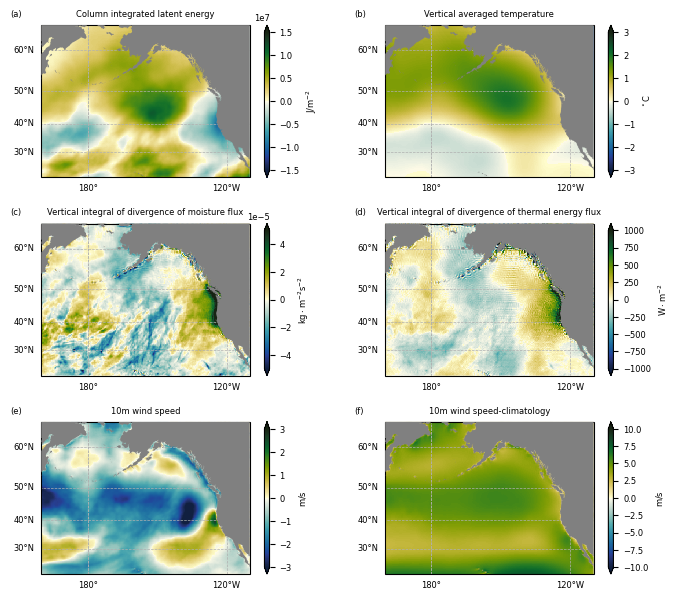

In [41]:
fig = plt.figure(figsize = (180*mm,155*mm))
# gs = GridSpec(2,2)
vmaxs = [1.5e7,3,5e-5,1000,3]
for i,var in enumerate(['latent','tm','div_q','div_t','wspd']):
    print(var)
    ax = plt.subplot(3,2,i+1,projection = projection)
    plt_small_map(ax,var,cmap = cmocean.cm.delta,fontsize = 6,shrink = 1,vmax = vmaxs[i])
    ax.set_title(f'({chr(97+i)})',loc = 'left',fontsize = 6,x = -0.15)
print('hey')
ax = plt.subplot(3,2,6,projection = projection)
plt_small_map(ax,'wspd',cmap = cmocean.cm.delta,fontsize = 6,shrink = 1,plot_anom = False,vmax = 10)
ax.set_title('10m wind speed-climatology',fontsize = 6)
ax.set_title('(f)',loc = 'left',fontsize = 6,x = -0.15)
plt.tight_layout()
plt.savefig('sup_heat_flux_more_2013.pdf',dpi = 300)